<a href="https://colab.research.google.com/github/MMIRRAHIM/2023_Machine-learning/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%224_introduction_to_pytorch_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Atalov S. (TSI AUCA)

## Introduction to PyTorch. Implementing simple Perceptron model

In [ ]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader


### Генерация данных
Сгенерируем датасет для примера

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

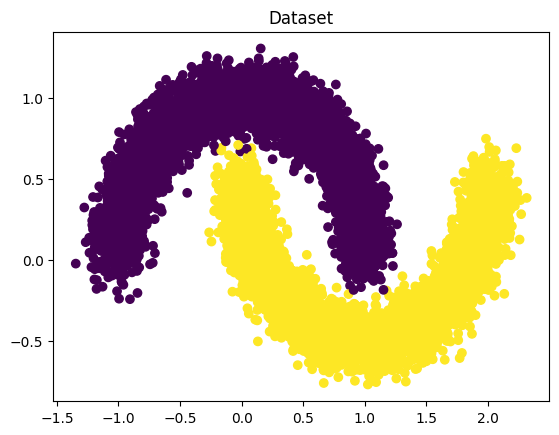

In [ ]:
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X_train.shape

(7500, 2)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

In [ ]:
# Train data as torch tensor
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Test data as torch tensor
X_test_t =  torch.tensor(X_test, dtype=torch.float32)
y_test_t =  torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
X_train_t.shape

torch.Size([7500, 2])

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(test_dataset, batch_size=128)

### Построение модели

In [ ]:
# Define the Perceptron model
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        # Single linear layer
        self.fc = nn.Linear(input_dim, 1) # fc means fully connected

    def forward(self, x):
        # Applying sigmoid activation function to get binary output
        z = self.fc(x)
        a = torch.sigmoid(z)
        return a



In [ ]:
Perceptron

__main__.Perceptron

In [ ]:
# Example: assuming we have 2 features in our dataset
input_dim = 2
model = Perceptron(input_dim)

In [ ]:
# Model parameters
model.parameters()

[Parameter containing:
 tensor([[ 1.1701, -4.6657]], requires_grad=True),
 Parameter containing:
 tensor([0.5557], requires_grad=True)]

In [ ]:
list(model.parameters())

In [ ]:
for name, param in model.named_parameters():
    print(name, param.data)

fc.weight tensor([[-0.0697, -0.1450]])
fc.bias tensor([-0.4807])


### Лосс и оптимизация

In [ ]:
# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

optimizer = optim.SGD(model.parameters(), lr=0.05)  # Stochastic Gradient Descent

### Процесс обучения модели

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету.
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем предикты из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
  ```

### Тренировка модели

#### Epochs
Произошла одна эпоха (epoch) — весь датасет прошел через нейронную сеть в прямом и обратном направлении только один раз.

Так как одна эпоха слишком велика для используемой вычислительной мощности, датасет делят на маленькие партии — батчи.

#### Batch Size в нейронных сетях
Размер батча — это общее число тренировочных объектов, представленных в одном батче.

Отметим: Размер батча и число батчей — два разных параметра.

Что такое батч?
Нельзя пропустить через нейронную сеть разом весь датасет. Поэтому делим данные на пакеты, сеты или партии.

In [ ]:
# parameters before training

for name, param in model.named_parameters():
    print(name, param.data)

In [ ]:
losses = [] # to store average loss of every epoch

num_epochs = 50  # Number of epochs

# Sample training loop
for epoch in range(num_epochs):  # loop over the dataset multiple times
    epoch_loss = 0.
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()  # zero the parameter gradients

        outputs = model(inputs)  # forward pass

        loss = criterion(outputs, labels)  # compute loss (y_pred, y)

        loss.backward()  # backward pass (calculate gradients)

        optimizer.step()  # update weights (w = w - lr*dj/dw)

        epoch_loss += loss.item()  # Summing up the loss for each batch

    losses.append(epoch_loss / len(train_dataloader))  # Average loss for the epoch

In [ ]:
# Parameters after training
for name, param in model.named_parameters():
    print(name, param.data)

fc.weight tensor([[ 1.1701, -4.6657]])
fc.bias tensor([0.5557])


### Лосс и эпохи

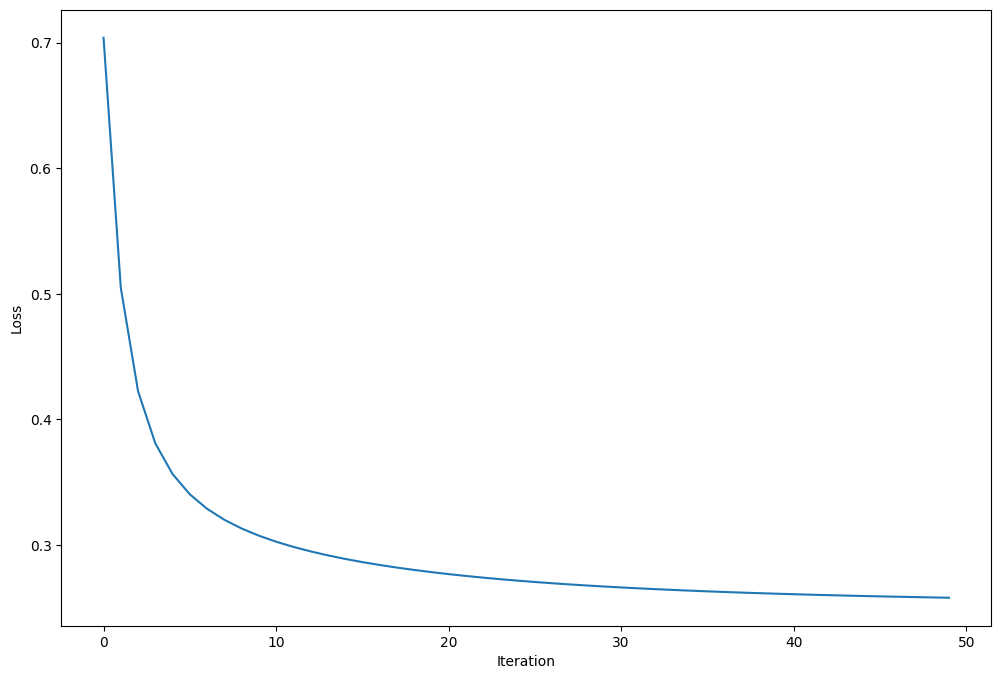

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Проверка точности модели

In [ ]:
# Example evaluation code
with torch.no_grad():
    # predict
    y_pred = model(X_test_t)
    # probability to 0 or 1
    y_pred_class = y_pred.round()
    # accuracy = true / all
    accuracy = (y_pred_class.eq(y_test_t).sum() / float(y_test_t.shape[0])).item()
    print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.8904


In [ ]:
y_pred = y_pred_class.numpy()

In [ ]:
plt.title("Dataset")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.show()

In [ ]:
y_pred

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)